In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
path = os.path.join('..', 'data', 'interim', '02_S_Stercoralis_fps.pkl')
df = pd.read_pickle(path)

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# reducing sample size
actives = df[df['ACTIVITY'] == 1]
inactives = df[df['ACTIVITY'] == 0]
new_df = shuffle(pd.concat([actives, inactives[:7000]]))

# splitting into train and test data
X = df.loc[:, df.columns != 'ACTIVITY']
y = df['ACTIVITY']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.3, shuffle=True)

In [4]:
active_train = y_train.value_counts()[1]
active_test = y_test.value_counts()[1]
inactive_train = y_train.value_counts()[0]
inactive_test = y_test.value_counts()[0]

data = [[active_train, active_test], [inactive_train, inactive_test]]

pd.DataFrame(data, index=['active', 'inactive'] , columns=['train', 'test'])

,train,test
active,2548,1105
inactive,18147,7765


sampling with near miss algorithm

In [5]:
from imblearn.under_sampling import NearMiss

nr = NearMiss()

X_resampled, y_resampled = nr.fit_resample(X_train, y_train.ravel())
y_resampled = pd.Series(y_resampled, index=X_resampled.index)
y_resampled.value_counts()

C:\Users\Gabriel Anyaele\AppData\Local\Temp\ipykernel_18192\3434457658.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_resampled, y_resampled = nr.fit_resample(X_train, y_train.ravel())


0    2548
1    2548
Name: count, dtype: int64

mutual Information

In [6]:
from sklearn.feature_selection import mutual_info_classif

# determine the mutual information
mutual_info = mutual_info_classif(X_resampled, y_resampled, discrete_features=True, random_state=56)
mutual_info = pd.Series(mutual_info, index=X_resampled.columns)

In [8]:
mutual_info.sort_values(ascending=False, inplace=True)

<Axes: title={'center': 'MI'}>

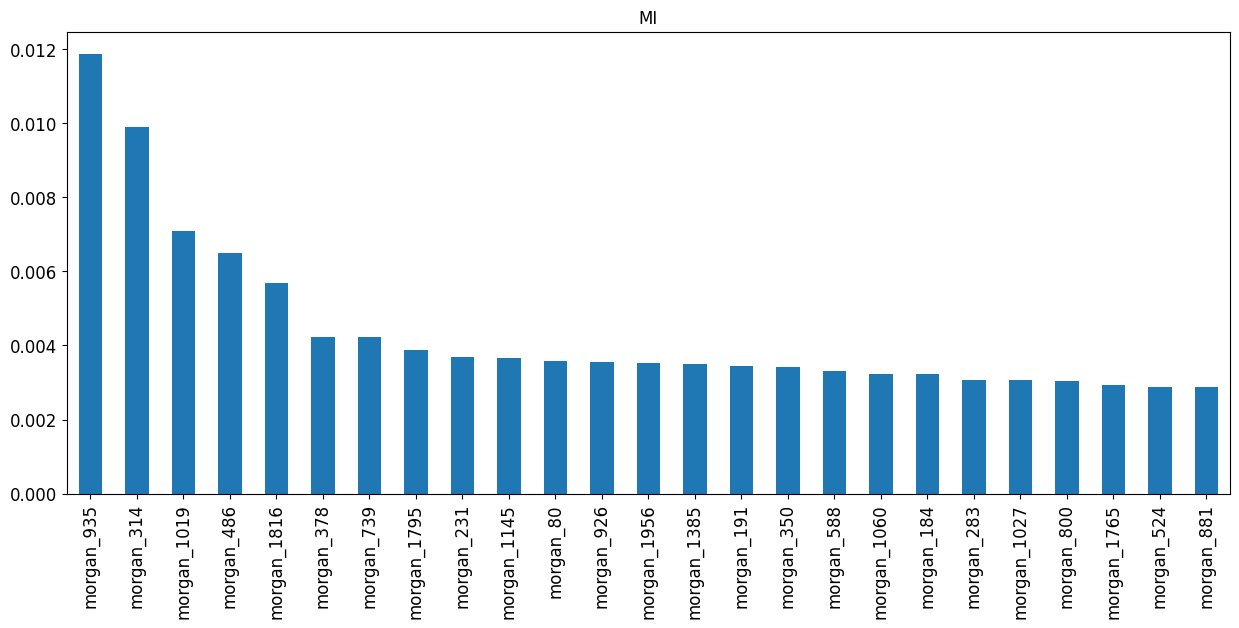

In [9]:
mutual_info[:25].plot(kind='bar', title="MI", figsize=(15 ,6), fontsize=12)

In [12]:
# A. Kraskov, H. Stogbauer and P. Grassberger, “Estimating mutual information”. Phys. Rev. E 69, 2004.


# list of all columns with mutual information greater than 0
selector_mask = list(mutual_info[mutual_info > 0.0001].index)
print('length of selected columns: ',len(selector_mask))
selector_mask[:5]

length of selected columns:  1282


['morgan_935', 'morgan_314', 'morgan_1019', 'morgan_486', 'morgan_1816']

In [13]:
X_resampled[selector_mask]

,morgan_935,morgan_314,morgan_1019,morgan_486,morgan_1816,morgan_378,morgan_739,morgan_1795,morgan_231,morgan_1145,...,morgan_644,morgan_1936,morgan_120,morgan_444,morgan_308,morgan_1320,morgan_1712,morgan_2006,morgan_1653,morgan_1259
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5091,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5092,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5093,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5094,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


cross validation

In [14]:
X_final = X_resampled[selector_mask]

In [22]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


knn = KNeighborsClassifier(n_neighbors = 3)
svc = SVC(kernel="rbf")
rfc = RandomForestClassifier(n_estimators=50)
rfc_cv_results = cross_validate(rfc, X_final, y_resampled, cv=5, scoring='recall')
svc_cv_results = cross_validate(svc, X_final, y_resampled, cv =5, scoring="recall")
knn_cv_results = cross_validate(knn, X_final, y_resampled, cv =5, scoring="recall")

In [20]:
rfc_cv_results

{'fit_time': array([2.10680795, 1.95524406, 2.05048156, 2.16722775, 2.14525151]),
 'score_time': array([0.069309  , 0.08432269, 0.09376168, 0.06819677, 0.08426261]),
 'test_score': array([0.55882353, 0.49901768, 0.56188605, 0.53333333, 0.58627451])}

In [21]:
svc_cv_results

{'fit_time': array([22.23252678, 22.90561152, 22.82426739, 21.99502397, 22.92129946]),
 'score_time': array([7.8907783 , 7.48813009, 7.4051187 , 7.33131695, 5.91187429]),
 'test_score': array([0.61764706, 0.5913556 , 0.61689587, 0.63137255, 0.63529412])}

In [23]:
knn_cv_results

{'fit_time': array([0.26059294, 0.18197465, 0.15600061, 0.15374684, 0.19199681]),
 'score_time': array([0.40011454, 0.33636332, 0.3302474 , 0.36515784, 0.3841567 ]),
 'test_score': array([0.32352941, 0.22986248, 0.24165029, 0.24705882, 0.25490196])}

grid search with svc

In [24]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.001, 0.0001],
    'kernel': ['rbf']
}


grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_final, y_resampled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.501 total time=  35.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=  35.8s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=  36.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=  35.7s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=  36.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.655 total time=  33.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.671 total time=  33.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.636 total time=  32.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.634 total time=  33.5s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.644 total time=  33.4s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.577 total time=  36.7s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001], 'kernel': ['rbf']},
             verbose=3)

In [32]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.1, 0.01],
    'kernel': ['rbf', 'sigmoid', 'linear', 'poly']
}


grid2 = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=2)
grid2.fit(X_final, y_resampled)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV 1/2] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.626 total time=  25.2s
[CV 2/2] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.598 total time=  25.7s
[CV 1/2] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.622 total time=  17.6s
[CV 2/2] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.624 total time=  17.0s
[CV 1/2] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.625 total time=  14.5s
[CV 2/2] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.635 total time=  13.7s
[CV 1/2] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.540 total time=  17.5s
[CV 2/2] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.619 total time=  14.5s
[CV 1/2] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.631 total time=  21.9s
[CV 2/2] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.646 total time=  21.5s
[CV 1/2] END .C=0.1, gamma=0.01, kernel=sigmoid;, score=0.593 total time=  19.7s
[CV 2/2] END .C=0.1, gamma=0.01, kernel=sigmoid;

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01],
                         'kernel': ['rbf', 'sigmoid', 'linear', 'poly']},
             verbose=3)

## prediction

In [42]:
svc = SVC(C=10, gamma=0.001).fit(X_resampled, y_resampled)
y_pred_svc = svc.predict(X_test)

In [43]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc)
f1 = f1_score(y_test, y_pred_svc)

print(f'Accuracy: {round(accuracy * 100, 2)}')
print(f'Recall: {round(recall * 100, 2)}')
print(f'f1-score: {round(f1 * 100, 2)}')


Accuracy: 33.62
Recall: 62.9
f1-score: 19.1


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

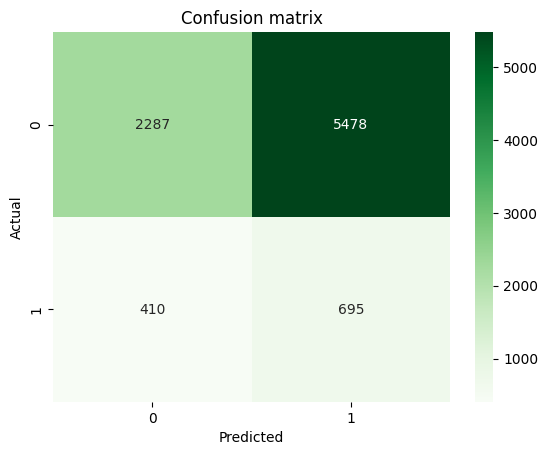

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_svc)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svc).ravel()

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens')

#labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels([ '0', '1'])
ax.yaxis.set_ticklabels([ '0', '1'])


#  (7689, 76, 1031, 74)  (tn, fp, fn, tp)

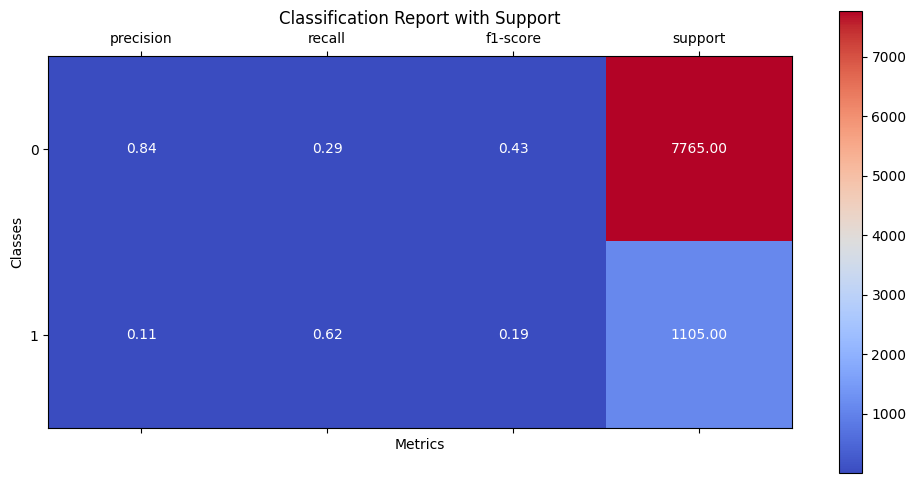

In [38]:
import matplotlib.pyplot as plt


def plot_classification_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    keys = ['0', '1']

    metrics = ['precision', 'recall', 'f1-score', 'support']
    data = np.array([[report[key][metric] for metric in metrics] for key in keys])
    fig, ax = plt.subplots(figsize=(12, 6))
    cax = ax.matshow(data, cmap='coolwarm')
    plt.xticks(range(len(metrics)), metrics)
    plt.yticks(range(len(keys)), keys)
    plt.colorbar(cax)
    # Adding the text
    for (i, j), val in np.ndenumerate(data):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.title('Classification Report with Support')
    plt.show()
    

plot_classification_report(y_test, y_pred_svc)

In [26]:
# from sklearn.feature_selection import VarianceThreshold

# selector = VarianceThreshold(threshold=0.1).fit(df.loc[:,df.columns != 'ACTIVITY'])
# variance_mask = selector.get_support()

In [20]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)

selector.fit_transform(df.loc[:,df.columns != 'ACTIVITY']).shape



(29565, 53)

# rfc

In [45]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {
    'n_estimators': [100, 300, 500, 700, 1000, 1500],
    'criterion': ['gini', 'entropy', 'log_loss']
}


grid_rfc = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3, cv=2)
grid_rfc.fit(X_final, y_resampled)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END ..criterion=gini, n_estimators=100;, score=0.554 total time=   1.8s
[CV 2/2] END ..criterion=gini, n_estimators=100;, score=0.603 total time=   1.8s
[CV 1/2] END ..criterion=gini, n_estimators=300;, score=0.553 total time=   5.0s
[CV 2/2] END ..criterion=gini, n_estimators=300;, score=0.615 total time=   5.7s
[CV 1/2] END ..criterion=gini, n_estimators=500;, score=0.566 total time=   9.6s
[CV 2/2] END ..criterion=gini, n_estimators=500;, score=0.611 total time=   8.9s
[CV 1/2] END ..criterion=gini, n_estimators=700;, score=0.554 total time=  12.9s
[CV 2/2] END ..criterion=gini, n_estimators=700;, score=0.608 total time=  17.4s
[CV 1/2] END .criterion=gini, n_estimators=1000;, score=0.562 total time=  17.9s
[CV 2/2] END .criterion=gini, n_estimators=1000;, score=0.610 total time=  17.3s
[CV 1/2] END .criterion=gini, n_estimators=1500;, score=0.558 total time=  24.6s
[CV 2/2] END .criterion=gini, n_estimators=1500;

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [100, 300, 500, 700, 1000, 1500]},
             verbose=3)